In [1]:
! pip install langchain-core langgraph >0.2.27

In [6]:
! pip install -U langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [2]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [3]:
from langchain_core.messages import HumanMessage, AIMessage
model.invoke([HumanMessage(content="Hello")])

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--d4470038-7c02-4d6a-8947-a43a81562889-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [4]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00


In [5]:
! pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 1.8 MB/s eta 0:00:00


In [7]:
#open ai embedding model
# import getpass
# import os

# if not os.environ.get("OPENAI_API_KEY"):
#   os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [14]:
#Gemini embedding model
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")


In [8]:
! pip install -qU langchain-community

In [12]:
! pip install -qU faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 43.8 MB/s eta 0:00:00


In [16]:
#using fiass vecto store to store embeddings
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

embedding_dim = len(embeddings.embed_query("hello world"))
print(embedding_dim)
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

768


In this guide we’ll build an app that answers questions about the website's content. The specific website we will use is the LLM Powered Autonomous Agents blog post by Lilian Weng, which allows us to ask questions about the contents of the post.

We can create a simple indexing pipeline and RAG chain to do this in ~50 lines of code

In [18]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [19]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is a technique used to enhance model performance on complex tasks by breaking them down into smaller, simpler steps. This can be achieved through methods like chain of thought prompting, task-specific instructions, or human input. Another approach involves using an external classical planner to do long-horizon planning.


# Query analysis
So far, we are executing the retrieval using the raw input query. However, there are some advantages to allowing a model to generate the query for retrieval purposes. For example:

In addition to semantic search, we can build in structured filters (e.g., "Find documents since the year 2020.");
The model can rewrite user queries, which may be multifaceted or include irrelevant language, into more effective search queries.
Query analysis employs models to transform or construct optimized search queries from raw user input. We can easily incorporate a query analysis step into our application. For illustrative purposes, let's add some metadata to the documents in our vector store. We will add some (contrived) sections to the document which we can filter on later.

In [21]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = model.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [25]:
from IPython.display import Image, display

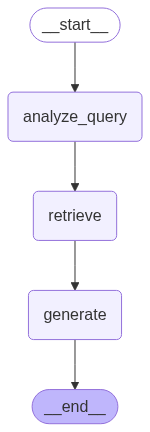

In [26]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
for step in graph.stream(
    {"question": "What does the begining of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='abf82a11-2b8e-491b-bf93-951faae39a56', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multip

In [27]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='b615a8d2-edc1-4811-8742-9b821aeb23c9', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='Here are a sample conversation for task clarification sent to OpenAI ChatCompletion endpoint used by GPT-Engineer. The user inputs are wrapped in {{user input text}}.\n[\n  {\n    "role": "system",\n    "content": "You will read instructions and not carry them out, only seek to clarify them.\\nSpecifically you will first summarise a list of super short bullets of areas that need clarification.\\nThen you will pick one clarifying question, and wait for an answer from the user.\\n"\n  },\n  {\n    "role": "user",\n    "content": "We are writing {{a Super Mario game in python. MVC components split in separate files. Keyboard control.}}\\n"\n  },\n  {\n    "role": "assistant",'), Document(id='3b756659-877c-41

In [28]:
for step in graph.stream(
    {"question": "What does the middle of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'middle'}}}

----------------

{'retrieve': {'context': [Document(id='fd928a86-3071-4949-a6aa-8692d29180b3', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'middle'}, page_content="(3) Task execution: Expert models execute on the specific tasks and log results.\nInstruction:\n\nWith the input and the inference results, the AI assistant needs to describe the process and results. The previous stages can be formed as - User Input: {{ User Input }}, Task Planning: {{ Tasks }}, Model Selection: {{ Model Assignment }}, Task Execution: {{ Predictions }}. You must first answer the user's request in a straightforward manner. Then describe the task process and show your analysis and model inference results to the user in the first person. If inference results contain a file path, must tell the user the complete file path."), Document(id='ef2f6c3b-5a02-4079-857d-f4d47d11a416', metadata={

In [29]:
for step in graph.stream(
    {"question": "What does this post says about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='abf82a11-2b8e-491b-bf93-951faae39a56', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multip

# AGENTIC RAG
In this tutorial we will build a retrieval agent. Retrieval agents are useful when you want an LLM to make a decision about whether to retrieve context from a vectorstore or respond to the user directly.

By the end of the tutorial we will have done the following:

Fetch and preprocess documents that will be used for retrieval.
Index those documents for semantic search and create a retriever tool for the agent.
Build an agentic RAG system that can decide when to use the retriever tool.

In [2]:
! pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters

In [4]:
# import getpass
# import os


# def _set_env(key: str):
#     if key not in os.environ:
#         os.environ[key] = getpass.getpass(f"{key}:")


# _set_env("OPENAI_API_KEY")

In [5]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
# from langchain_core.vectorstores import InMemoryVectorStore
# from langchain_openai import OpenAIEmbeddings

# vectorstore = InMemoryVectorStore.from_documents(
#     documents=doc_splits, embedding=OpenAIEmbeddings()
# )
# retriever = vectorstore.as_retriever()

In [7]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [8]:
from langchain_core.vectorstores import InMemoryVectorStore
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()


Create a retriever tool using LangChain's prebuilt create_retriever_tool:

In [9]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [10]:
retriever_tool.invoke({"query": "types of reward hacking"})

'(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nReward hacking examples in LLM tasks#\n\nA language model for generating summarization is able to explore flaws in the ROUGE metric such that it obtains high score but the generated summaries are barely readable. (Link)\nA coding model learns to change unit test in order to pass coding questions. (Link)\nA coding model may learn to directly modify the code used for calculating the reward. (Link)\n\nReward hacking examples in real life#\n\nAmodei et al. (2016) summarized that reward hacking, mainly in RL setting, may occur due to:\n\nReward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely l

Now we will start building components (nodes and edges) for our agentic RAG graph. Note that the components will operate on the MessagesState — graph state that contains a messages key with a list of chat messages.

1. Build a generate_query_or_respond node. It will call an LLM to generate a response based on the current graph state (list of messages). Given the input messages, it will decide to retrieve using the retriever tool, or respond directly to the user. Note that we're giving the chat model access to the retriever_tool we created earlier via .bind_tools

In [12]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("gemini-2.0-flash", model_provider="google_genai",temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

in case of generic query it wont go to retrieve node at all, where as queries that requires semantic retrieval agent will call retrieval node and then generate node


In [13]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


In [14]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (e71aa5c8-adac-4e93-9481-97ece1d95d93)
 Call ID: e71aa5c8-adac-4e93-9481-97ece1d95d93
  Args:
    query: types of reward hacking


1. Add a conditional edge — grade_documents — to determine whether the retrieved documents are relevant to the question. We will use a model with a structured output schema GradeDocuments for document grading. The grade_documents function will return the name of the node to go to based on the grading decision (generate_answer or rewrite_question):


In [17]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("gemini-2.0-flash",model_provider="google_genai",temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

Rewrite question¶
1. Build the rewrite_question node. The retriever tool can return potentially irrelevant documents, which indicates a need to improve the original user question. To do so, we will call the rewrite_question node:

In [18]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [19]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [20]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

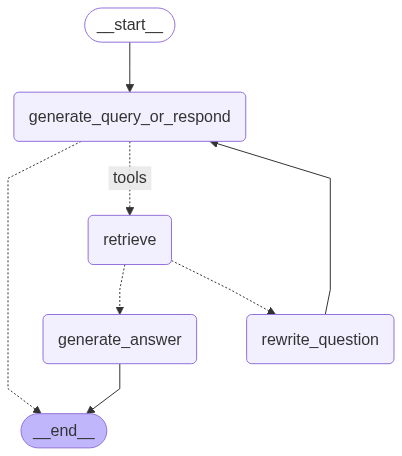

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (00ce3423-049c-4e14-b2f7-fa0b466d2a40)
 Call ID: 00ce3423-049c-4e14-b2f7-fa0b466d2a40
  Args:
    query: types of reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.

Reward hacking examples in LLM tasks#

A language model for generating summarization is able to explore flaws in the ROUGE metric such that it obtains high score but the generated summaries are barely readable. (Link)
A coding model learns to change unit test in order to pass co